### Table of contents
[Predefined functions](#funcs)

[Parameters, filenames and directories](#params)

[Reading maps and catalogs](#read)

[Function for plotting statistics for different outlCoeff](#plotStatOutlCoeff)

[SpecZ outlier filtering](#specZ)

[PhotoZ_ML outlier filtering](#photoZ_ML)

[PhotoZ_SED outlier filtering](#photoZ_SED)

[ActivMap filtering](#activMap)

In [18]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from func_maps import readMaps
from func_stat import *
from func_visualizations import *
from os.path import join
from ast import literal_eval

### Parameters, filenames and directories
<a id='params'>#params</a>

In [12]:
### Files and directories ###
dirSOM=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\SOM\forArticle'
nameOfExperiment='ex017'
dirMaps=join(dirSOM,nameOfExperiment,'maps')
dirPlots=join(dirSOM,nameOfExperiment,'plots')
dirDatasets=join(dirSOM,nameOfExperiment,'datasets')
mapsAllKeys=['mapsTrainOnTrain','mapsTestOnTrain','mapsDeimosOnTrain','mapsRunOnTrain',
             'mapsTrainOnRun','mapsTestOnRun','mapsDeimosOnRun','mapsRunOnRun',
             'mapsTrainOnRunBig','mapsTestOnRunBig','mapsDeimosOnRunBig','mapsRunOnRunBig']

In [34]:
datasetNames={'Train':r'05_COSMOS_SpectrZ_Zlim_1p2_SOMinfo.csv',
              'Test':r'05_COSMOS_SpectrZ_Zlim_1p2_Test_SOMinfo.csv',
              'Deimos':r'04_COSMOS_DEIMOS_QfFilter_SOMinfo.csv',
              'Run':r'04_COSMOS2015_run_WorkBands_SOMinfo.csv'}

In [35]:
idCol='Seq'
specZ='specZ'
photoZ_ML='photoZ_ML'
photoZ_SED='photoZ_SED'
residML='resid_ML'
residSED='resid_SED'
residML_SED='residML_SED'
quantErr='quantErr'

In [36]:
### Format for saving images ###
imSaveFormat='.png'
#imSaveFormat='.eps'

### Reading datasets
<a id='read'>#read</a>

In [37]:
datasets={}
cellIDs=['cellID_TrainSOM','cellID_RunSOM','cellID_RunBigSOM']
for key,val in datasetNames.items():
    datasets[key]=pd.read_csv(join(dirDatasets,val))
    for cellID in cellIDs:
        datasets[key][cellID]=[literal_eval(x) for x in datasets[key][cellID]]

### Calculating statistics
<a id='statDeclare'>#statDeclare</a>
<p>Since we have a bit too many statistical tables, they are stashed in one dictionary. It's structure is as follows:</p>
    <br>Dictionary statAll has keys which correspond to datasets.
    <br>For each key we have a dictionary which keys correspond to stat table names. We have: 
    <br>- 'basic' table, which corresponds to different cases of cleaning (None, SpecZ, PhotoZ, activMap and their combinations);
    <br>- 'magBin' table, which describes statistics within magnitude bins;
    <br>- 'oultCoeff' for specZ, SED and ML photoZ, which describe statistics within each bin of outlier coefficients;
    <br>- 'activMap' table, which describes statistics for different occupations of cells;
    <br>- probably something else.

In [66]:
statAll={name:{} for name in datasetNames.keys()}

In [67]:
### Calculate statistics for objects with different outlCoeff ###
cases=[specZ,photoZ_ML,photoZ_SED]
residCols=[residML,residSED,residML_SED]
bins=np.arange(-5, 5.5,step=0.5)
for name in statAll.keys():
    for c in cases:
        if name=='Run':
            if c==specZ:
                continue
            else:
                statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=[residML_SED],bins=bins)
        else:
            statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=residCols,bins=bins)

### Function for plotting statistics for different outlCoeff
<a id='plotStatOutlCoeff'>#plotStatOutlCoeff</a>

In [75]:
def plotStatsForOutlCoeff(data,case,stats,datasetNames):
    fig,axs=plt.subplots(6,2,figsize=(15,15),sharey='row',sharex='col')
    estimators=['Std','NMAD','Mean','% outl_15']
    c=case
    i=0
    lims=(-3,3)
    for j,d in enumerate(data):
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid')

    i=1
    for j,s in enumerate(stats):
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c]['General']['binEdge'],s['outlCoeff_'+c]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects')

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            s=s['outlCoeff_'+c][(s['outlCoeff_'+c]['General']['binEdge']>=lims[0]) & (s['outlCoeff_'+c]['General']['binEdge']<=lims[1])]
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est)
    axs[-1][0].set_xlabel(c+' outlCoeff\n'+ datasetNames[0]+' dataset')
    axs[-1][1].set_xlabel(c+' outlCoeff\n'+ datasetNames[1]+' dataset')
    plt.tight_layout()
    return fig

### SpecZ outlier filtering
<a id='specZ'>#specZ</a>

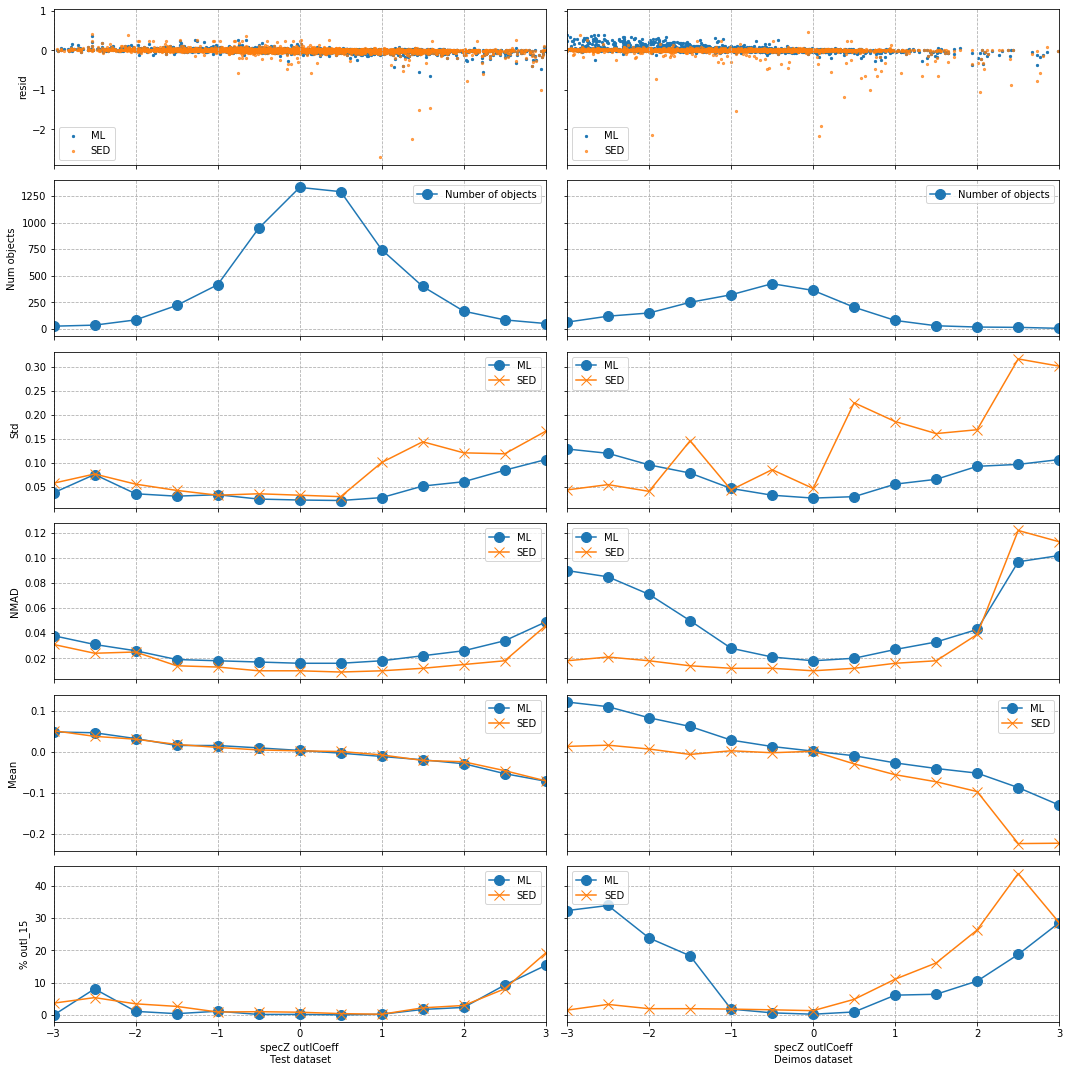

In [77]:
### Plot statistics for different outlCoeff ###
datasetNames=['Test','Deimos']
data=[datasets[name] for name in datasetNames]
stats=[statAll[name] for name in datasetNames]
case=specZ
fig=plotStatsForOutlCoeff(data,case,stats,datasetNames)

### PhotoZ_ML outlier filtering
<a id='PhotoZ_ML'>#PhotoZ_ML</a>

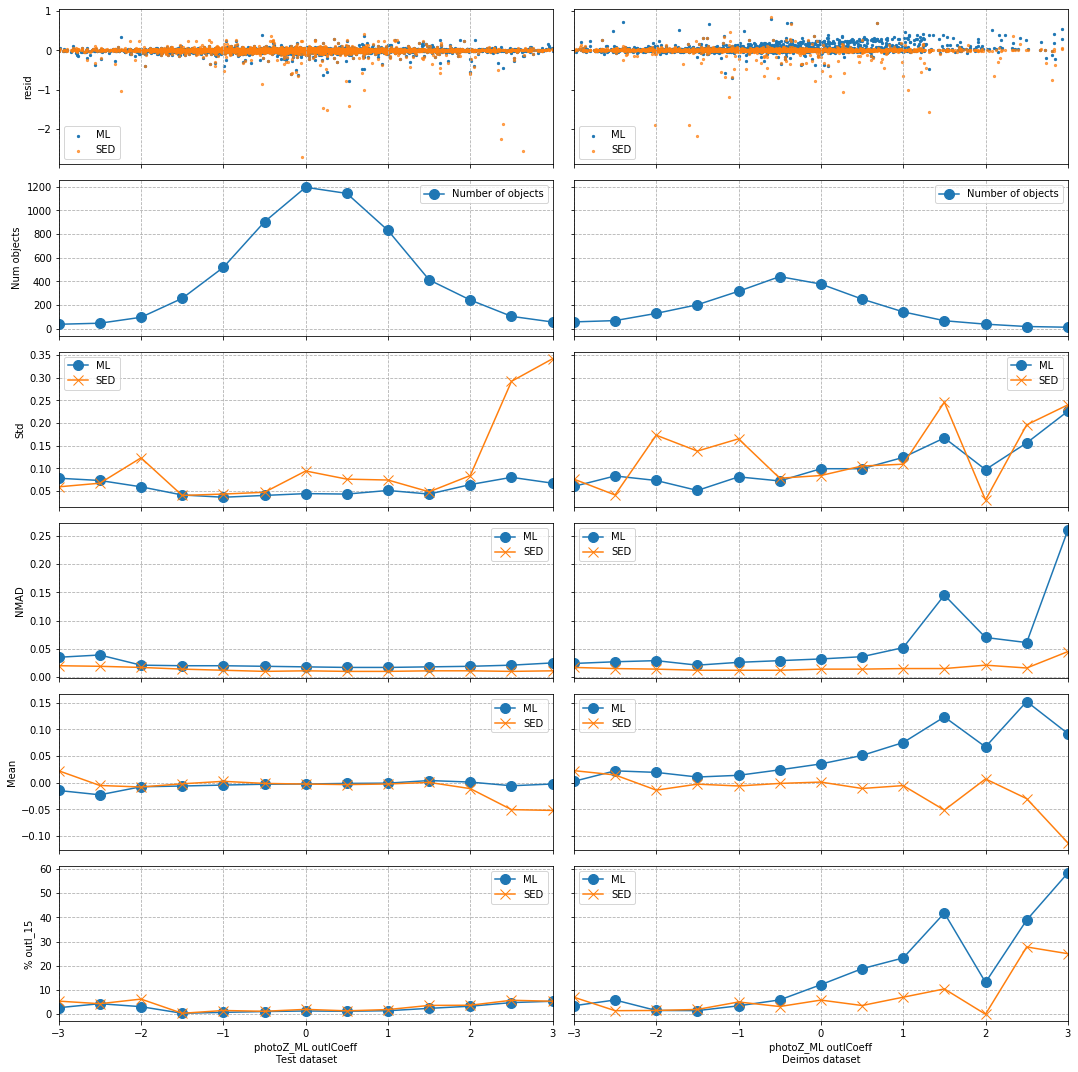

In [78]:
### Plot statistics for different outlCoeff ###
datasetNames=['Test','Deimos']
data=[datasets[name] for name in datasetNames]
stats=[statAll[name] for name in datasetNames]
case=photoZ_ML
fig=plotStatsForOutlCoeff(data,case,stats,datasetNames)

### PhotoZ_SED outlier filtering
<a id='PhotoZ_SED'>#PhotoZ_SED</a>

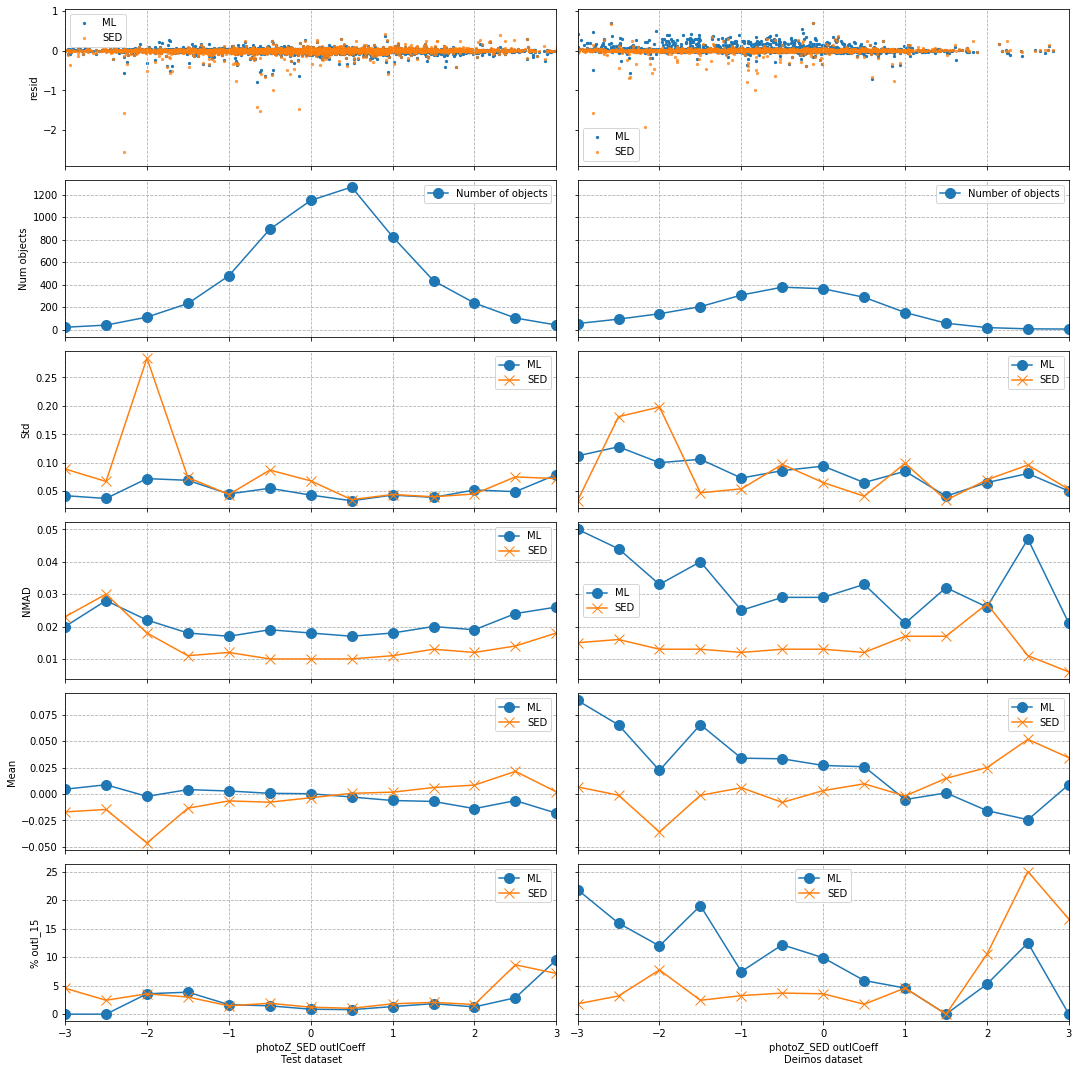

In [79]:
### Plot statistics for different outlCoeff ###
datasetNames=['Test','Deimos']
data=[datasets[name] for name in datasetNames]
stats=[statAll[name] for name in datasetNames]
case=photoZ_SED
fig=plotStatsForOutlCoeff(data,case,stats,datasetNames)

### ActivMap filtering
<a id='activMap'>#activMap</a>